# Raster API tutorial
## opening the File

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import pandas as pd

In [2]:
font = {'family':'Times New Roman', 'weight':'bold', 'size':14}
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rc('font', **font)

In [3]:
cdict = np.array([(255,0,0), (85,255,0), (255,255,0), (115,223,255),(38,115,0),
             (255,190,232),(128,222,153),(0,92,230)])/255 
cdict

array([[1.        , 0.        , 0.        ],
       [0.33333333, 1.        , 0.        ],
       [1.        , 1.        , 0.        ],
       [0.45098039, 0.8745098 , 1.        ],
       [0.14901961, 0.45098039, 0.        ],
       [1.        , 0.74509804, 0.90980392],
       [0.50196078, 0.87058824, 0.6       ],
       [0.        , 0.36078431, 0.90196078]])

In [4]:
def colormap():
    # color
    cdict = np.array([(255,0,0), (85,255,0), (255,255,0), (115,223,255),(38,115,0),
             (255,190,232),(128,222,153),(0,92,230)])/255 
    return colors.ListedColormap(cdict, 'indexed',8)

In [5]:
my_cmap = colormap()

In [6]:
# read tif
file = "Data/hongkong/imgs_1/S2A_OPER_MSI_L1C_TL_SGS__20160927T081713_A006607_T49QHE_B01.tif"
# file = "Data/AerialImageDataset/train/austin1.tif"
dataset = gdal.Open(file, gdal.GA_ReadOnly) 
rasterArray = dataset.ReadAsArray()

In [7]:
# rasterArray = np.moveaxis(rasterArray, 0, -1) 
rasterArray.shape, type(rasterArray)

((116, 90), numpy.ndarray)

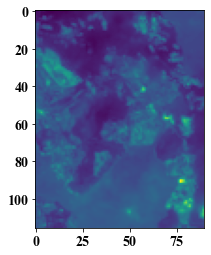

In [8]:
# plt.figure(figsize = (10,10))
plt.imshow(rasterArray)
plt.show()

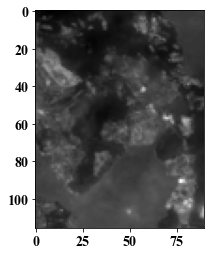

In [9]:
plt.imshow(rasterArray, cmap= 'gray')

# Getting Dataset Information

As described in the Raster Data Model, a GDALDataset contains a list of raster bands, all pertaining to the same area, and having the same resolution. It also has metadata, a coordinate system, a georeferencing transform, size of raster and various other information.

In the particular, but common, case of a “north up” image without any rotation or shearing, the georeferencing transform Geotransform Tutorial takes the following form :

```python
adfGeoTransform[0] /* top left x */
adfGeoTransform[1] /* w-e pixel resolution */
adfGeoTransform[2] /* 0 */
adfGeoTransform[3] /* top left y */
adfGeoTransform[4] /* 0 */
adfGeoTransform[5] /* n-s pixel resolution (negative value) */
```

In [10]:
print("Driver: {}/{}\n".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is (W, H, D): {} x {} x {}\n".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}\n".format(dataset.GetProjection()))

geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Driver: GTiff/GeoTIFF

Size is (W, H, D): 90 x 116 x 1

Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]

Origin = (114.22811508178711, 22.34134341446177)
Pixel Size = (0.0005607604980467171, -0.0005599516087156652)


# Fetching a Raster Band
At this time access to raster data via GDAL is done one band at a time. Also, there is metadata, block sizes, color tables, and various other information available on a band by band basis. The following codes fetches a GDALRasterBand object from the dataset (numbered 1 through GDALRasterBand::GetRasterCount()) and displays a little information about it.

In [11]:
band = dataset.GetRasterBand(1)
print("Band Count={}".format(dataset.RasterCount))
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()

if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

  
    
    

Band Count=1
Band Type=UInt16
Min=1241.000, Max=2478.000


# Reading Raster Data

There are a few ways to read raster data, but the most common is via the GDALRasterBand::RasterIO() method. This method will automatically take care of data type conversion, up/down sampling and windowing. 

The following code will read the first scanline of data into a similarly sized buffer, converting it to floating point as part of the operation.

In [12]:
scanline = band.ReadRaster(xoff=0, yoff=0,
                        xsize=band.XSize, ysize=1,
                        buf_xsize=band.XSize, buf_ysize=1,
                        buf_type=gdal.GDT_Float32)
# scanline

In [13]:
rasterArray = dataset.ReadAsArray()
print("Size is (Row:Height Column:Width) : {} x {}\n".format(rasterArray.shape[0], rasterArray.shape[1]))


Size is (Row:Height Column:Width) : 116 x 90



# Techniques for Creating Files
New files in GDAL supported formats may be created if the format driver supports creation. There are two general techniques for creating files, using CreateCopy() and Create(). 

The CreateCopy method involves calling the CreateCopy() method on the format driver, and passing in a source dataset that should be copied. 

The Create method involves calling the Create() method on the driver, and then explicitly writing all the metadata, and raster data with separate calls. All drivers that support creating new files support the CreateCopy() method, but only a few support the Create() method.

In [14]:
fileformat = "GTiff"
driver = gdal.GetDriverByName(fileformat)
metadata = driver.GetMetadata()

if metadata.get(gdal.DCAP_CREATE) == "YES":
    print("Driver {} supports Create() method.".format(fileformat))

if metadata.get(gdal.DCAP_CREATECOPY) == "YES":
    print("Driver {} supports CreateCopy() method.".format(fileformat))

Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.


# Using CreateCopy()
The GDALDriver::CreateCopy() method can be used fairly simply as most information is collected from the source dataset. However, it includes options for passing format specific creation options, and for reporting progress to the user as a long dataset copy takes place. A simple copy from the a file named pszSrcFilename, to a new file named pszDstFilename using default options on a format whose driver was previously fetched might look like this:

In [15]:
src_filename = file
dst_filename = "copy.tif"
src_ds = gdal.Open(src_filename)
dst_ds = driver.CreateCopy(dst_filename, src_ds, strict=0)
# Once we're done, close properly the dataset
dst_ds = None
src_ds = None
dataset = None

In [16]:
!ls | grep copy

copy.tif
copy2.tif


In [17]:
save_img_path = "copy2.tif"
# convert array
from osgeo import gdal_array
output = gdal_array.SaveArray(rasterArray,
                              save_img_path,
                              format="GTiff",
                              prototype=file) # save image with prototype 

In [18]:
!ls | grep copy

copy.tif
copy2.tif


In [19]:
dataset = gdal.Open(save_img_path, gdal.GA_ReadOnly) # same geo-reference

print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))

geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Driver: GTiff/GeoTIFF
Size is 90 x 116 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (114.22811508178711, 22.34134341446177)
Pixel Size = (0.0005607604980467171, -0.0005599516087156652)


In [20]:
!ls

Data          copy2.tif     explore.ipynb
copy.tif      data.py       new.tif


# Using Create()
For situations in which you are not just exporting an existing file to a new file, it is generally necessary to use the GDALDriver::Create() method (though some interesting options are possible through use of virtual files or in-memory files). The Create() method takes an options list much like CreateCopy(), but the image size, number of bands and band type must be provided explicitly.



In [21]:
dst_filename = "new.tif"

dst_ds = driver.Create(dst_filename, xsize=512, ysize=512,
                    bands=1, eType=gdal.GDT_Byte)

In [22]:
from osgeo import osr
import numpy

dst_ds.SetGeoTransform([444720, 30, 0, 3751320, 0, -30])
srs = osr.SpatialReference()
srs.SetUTM(11, 1)
srs.SetWellKnownGeogCS("NAD27")
dst_ds.SetProjection(srs.ExportToWkt())


# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x = np.linspace(-5, 5, 512)
y = np.linspace(-5, 5, 512)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
z = gaus2d(x, y)*255

# raster = numpy.eye(512, dtype=numpy.uint8)*255

raster = z.astype(numpy.uint8)

dst_ds.GetRasterBand(1).WriteArray(raster)
# Once we're done, close properly the dataset
dst_ds = None

In [23]:
z.max(), z.min(), raster.max(), raster.min()

(40.58062507058599, 5.636354034504054e-10, 40, 0)

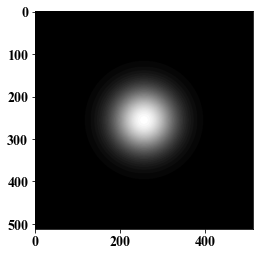

In [24]:
# read the created gaus2d images
dataset = gdal.Open(dst_filename, gdal.GA_ReadOnly) 
rasterArray = dataset.ReadAsArray()
plt.imshow(rasterArray, cmap='gray')
plt.show()


In [25]:
rasterArray.shape, rasterArray.dtype

((512, 512), dtype('uint8'))

In [26]:
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))

geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
dataset = None

Driver: GTiff/GeoTIFF
Size is 512 x 512 x 1
Projection is PROJCS["NAD27 / UTM zone 11N",GEOGCS["NAD27",DATUM["North_American_Datum_1927",SPHEROID["Clarke 1866",6378206.4,294.978698213898,AUTHORITY["EPSG","7008"]],AUTHORITY["EPSG","6267"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4267"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26711"]]
Origin = (444720.0, 3751320.0)
Pixel Size = (30.0, -30.0)


## The END
